# Анализ временных рядов
### Колесников Дмитрий

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure
from tqdm import tqdm
%matplotlib inline

### Ряды Фурье в задаче анализа временных рядов

**Задание 1 раздела:** <br>
    1. Оценить высокочастотную периодичность прироста новых случаев заболевания COVID (график "Прирост по дням")<br>
2. Определить даты, соответствующие наивысшим точкам каждой волны заболеваемости

In [2]:
df = pd.read_csv('COVID.csv')
df.shape

(976, 4)

In [3]:
df.head()

,DateTime,Заражений за день,Выздоровлений за день,Смертей за день
0,2020-03-12 00:00:00,34,0,0
1,2020-03-13 00:00:00,11,0,0
2,2020-03-14 00:00:00,14,0,0
3,2020-03-15 00:00:00,4,3,0
4,2020-03-16 00:00:00,28,2,0


In [4]:
df.dtypes

DateTime                 object
Заражений за день         int64
Выздоровлений за день     int64
Смертей за день           int64
dtype: object

In [5]:
df['DateTime'] = pd.to_datetime(df['DateTime'])

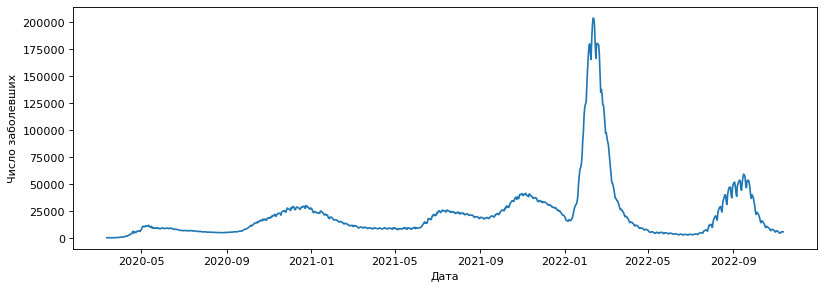

In [6]:
figure(figsize=(12, 4), dpi=80)
plt.plot(df.DateTime,df['Заражений за день'])
plt.xlabel('Дата')
plt.ylabel('Число заболевших');

Увидим высокочастотные колебания:

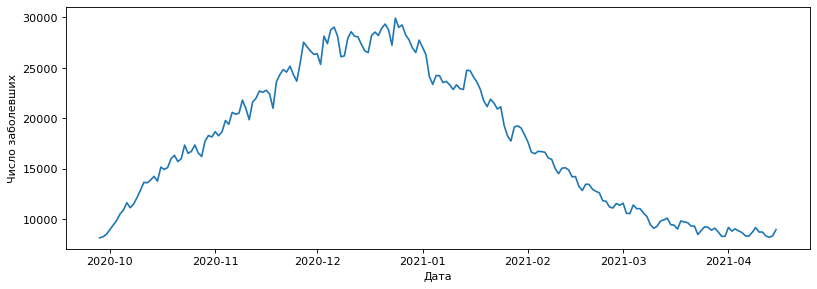

In [7]:
figure(figsize=(12, 4), dpi=80)
plt.plot(df.DateTime[200:400],df['Заражений за день'][200:400])
plt.xlabel('Дата')
plt.ylabel('Число заболевших');

In [8]:
Ts = np.mean(np.diff(df['DateTime'])) / np.timedelta64(1, 's')
Ts

86400.0

Найдем частоту дискретизации данных в Гц

In [9]:
Fs = 1 / Ts
Fs

1.1574074074074073e-05

In [10]:
znach = []
for i in range(df.shape[0]):
      znach.append(i*Ts)
len(znach)

976

In [11]:
df['seconds'] = znach

In [12]:
df.head()

,DateTime,Заражений за день,Выздоровлений за день,Смертей за день,seconds
0,2020-03-12,34,0,0,0.0
1,2020-03-13,11,0,0,86400.0
2,2020-03-14,14,0,0,172800.0
3,2020-03-15,4,3,0,259200.0
4,2020-03-16,28,2,0,345600.0


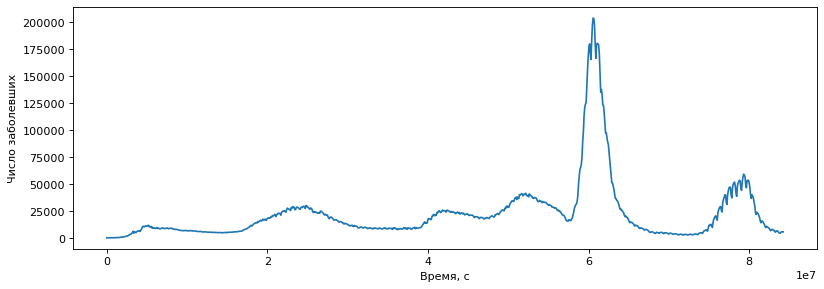

In [13]:
figure(figsize=(12, 4), dpi=80)
plt.plot(df.seconds,df['Заражений за день']);
plt.xlabel('Время, с')
plt.ylabel('Число заболевших');

Сделаем прямое преобразование Фурье

In [14]:
otch = np.fft.fft(df['Заражений за день'])
f =[]
for i in range(len(znach)):
    f.append(Fs * i / len(znach))

Построим график спектральной плотности сигнала:

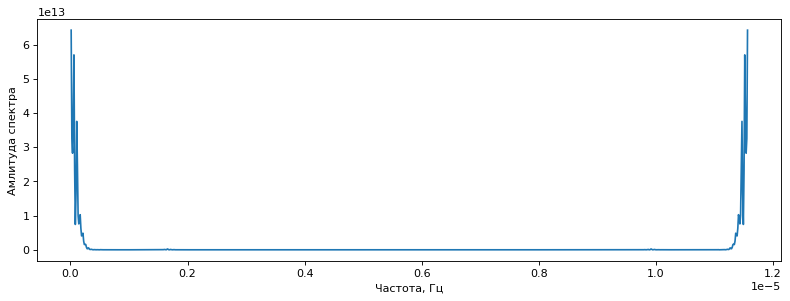

In [15]:
figure(figsize=(12, 4), dpi=80)
plt.plot(f[1:],(abs(otch)**2)[1:])
plt.xlabel('Частота, Гц')
plt.ylabel('Амлитуда спектра');

Определим, какие частоты имеют значимый вклад, то есть несут высокую энергию в исходном сигнале

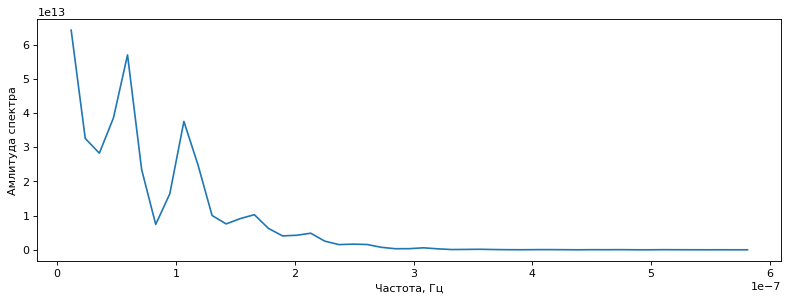

In [16]:
figure(figsize=(12, 4), dpi=80)
plt.plot(f[1:50],(abs(otch)**2)[1:50])
plt.xlabel('Частота, Гц')
plt.ylabel('Амлитуда спектра');

Частоты флуктаций составляет более 0.25 мкГц - Вызвано частотностью занесения в риестр и прочими случайностями. Иформативные изменения происходят с периодичностью более чем в 46 дней

In [17]:
print(str(int(1/(25*10**-8)/(60*60*24))),'дней')

46 дней


Проведем разложение в ряд фурье исходной функции 

In [18]:
otch = np.fft.fft(df['Заражений за день'])
re = otch.real
im = otch.imag
amp = np.zeros(len(znach))
for garmonica in range(int(len(znach)/2)):
    for t in range(len(znach)):
        amp[t] = amp[t] + ((1 / len(otch)) * (abs(otch[garmonica]) * np.cos(2 * np.pi / len(znach) * garmonica * t  + 
                                                                            np.angle(otch[garmonica]))))

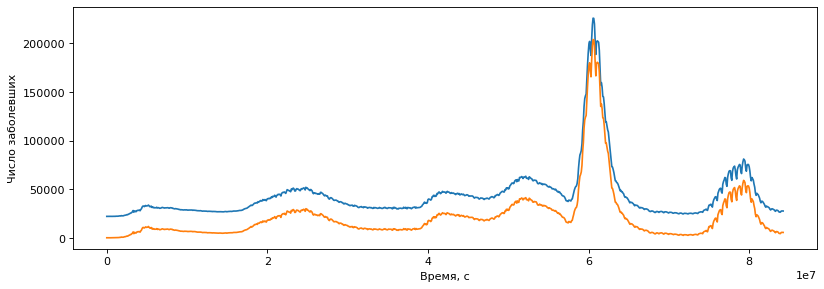

In [19]:
figure(figsize=(12, 4), dpi=80)
plt.plot(df.seconds,amp*2)
plt.plot(df.seconds,df['Заражений за день'])
plt.xlabel('Время, с')
plt.ylabel('Число заболевших');

Ограничим число гармоник и посмотрим как восстанавливается сигнал с их увеличением числа

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19.81it/s]


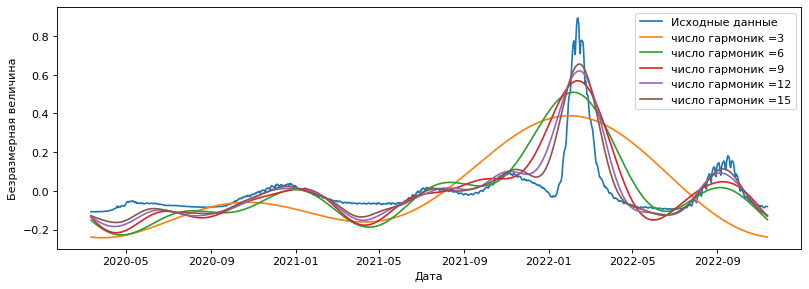

In [20]:
figure(figsize=(12, 4), dpi=80)
inf = df['Заражений за день']
plt.plot(df.DateTime,(inf-inf.mean())/max(inf),label='Исходные данные')
plt.xlabel('Дата')
plt.ylabel('Безразмерная величина');
amp = np.zeros(len(znach))
for j in tqdm(np.linspace(3, int(len(znach)/50), 5, endpoint=False)):
    for garmonica in range(int(j)):
        for t in range(len(znach)):
            amp[t] = amp[t] + ((1 / len(otch)) * (abs(otch[garmonica]) * np.cos(2 * np.pi / len(znach) * garmonica * t  + 
                                                                                np.angle(otch[garmonica]))))
    text = 'число гармоник ='+ str(int(j))
    plt.plot(df.DateTime,(amp-amp.mean())/max(amp), label=text)
plt.legend();

Без фильтров чтобы найти максимумы для каждой из волн коронавируса, надо аппроксимировать сигнал набором тригонометрических функций. С этим идеально справляется разложение в ряд Фурье. Ограничим число гармоник восьмью.  

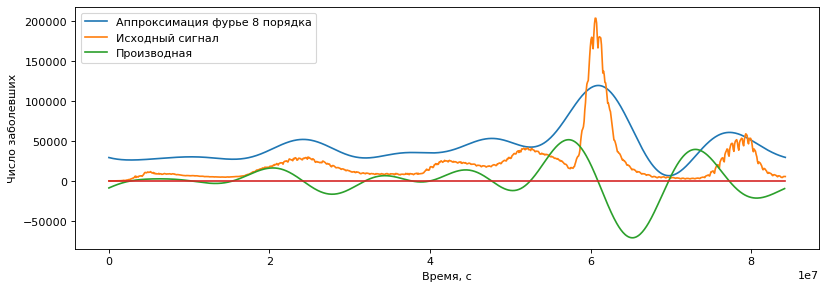

In [21]:
figure(figsize=(12, 4), dpi=80)
amp = np.zeros(len(znach))
for garmonica in range(8):
    for t in range(len(znach)):
        amp[t] = amp[t] + ((1 / len(otch)) * (abs(otch[garmonica]) * np.cos(2 * np.pi / len(znach) * garmonica * t  + 
                                                                            np.angle(otch[garmonica]))))
plt.plot(df.seconds, amp*2, label='Аппроксимация фурье 8 порядка')
plt.plot(df.seconds,df['Заражений за день'], label='Исходный сигнал')
plt.plot(df.seconds[:-1], np.diff(amp)*80, label='Производная')
plt.plot(df.seconds, np.zeros(len(amp)))
plt.xlabel('Время, с')
plt.ylabel('Число заболевших')
plt.legend();

Следующей целью найти максимумы. Это можно сделать с помошью производной и дальнейшего отбора подходящих локальных экстремумов

In [22]:
dif = np.diff(amp)

In [23]:
waves_max = []
waves_num = []
print('Дни пиков заражаемости в волнах:')
for i in range(1, len(dif)-1):
    if (abs(dif[i-1]) > abs(dif[i])) & (abs(dif[i+1]) > abs(dif[i])) & (dif[i-1] > 0) & (dif[i+1] < 0):
        print(df.DateTime[i])
        waves_max.append(df.DateTime[i])
        waves_num.append(i)

Дни пиков заражаемости в волнах:
2020-07-08 00:00:00
2020-12-17 00:00:00
2021-05-22 00:00:00
2021-09-15 00:00:00
2022-02-15 00:00:00
2022-08-23 00:00:00


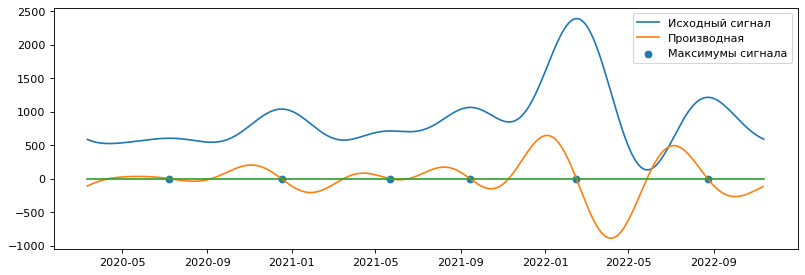

In [24]:
dif = np.diff(amp)
figure(figsize=(12, 4), dpi=80)
plt.plot(df.DateTime, amp*0.04, label='Исходный сигнал')
plt.plot(df.DateTime[:-1], np.diff(amp), label='Производная')
plt.plot(df.DateTime, np.zeros(len(amp)))
plt.scatter(waves_max, np.zeros(len(waves_max)), label='Максимумы сигнала')
plt.legend();

In [25]:
print('Число волн равяется', len(waves_max))

Число волн равяется 6


Выведем информацию по статистике в дни максимумов заражений для каждой из волн

In [26]:
df.query('DateTime in @waves_max')

,DateTime,Заражений за день,Выздоровлений за день,Смертей за день,seconds
118,2020-07-08,6562,8631,173,10195200.0
280,2020-12-17,28214,26440,587,24192000.0
436,2021-05-22,8709,9345,386,37670400.0
552,2021-09-15,18841,17039,792,47692800.0
705,2022-02-15,166631,137881,704,60912000.0
894,2022-08-23,30967,30869,69,77241600.0


---

### Фильтр Калмана для определения реальных положений тела в определенный момент времени

Рассмотрим задачу определения реального положения объекта. Допустим, что у нас есть математическая модель, которая с какой-то степенью точности описывает движение объекта. В то же время имеется на объекте датчик GPS который тоже нельзя назвать супер точным. Так что появляется задача прогнозирования по данным примерной мат модели и по примерным расчетам локатора реального положения в каждый момент времени. Для этого и используется фильтр Калмана.

Параметр g характеризует величину ошибки в координате согласно мат модели <br/>
Параметр h характеризует величину ошибки в скорости согласно мат модели в данный момент

In [27]:
def g_h_filter (data, x0, dx, g, h, dt=1., pred=None):
    """
    Performs g-h filter on 1 state variable with a fixed g and h.
    ’data’ contains the data to be filtered.
    ’x0’ is the initial value for our state variable
    ’dx’ is the initial change rate for our state variable
    ’g’ is the g-h’s g scale factor
    ’h’ is the g-h’s h scale factor
    ’dt’ is the length of the time step
    ’pred’ is an optional list. If provided, each prediction will
    be stored in it
    """
    x = x0
    results = []
    dxs = []
    for i, z in enumerate(data):
        #prediction step
        x_est = x + (dx*dt)
        dx = dx

        if pred is not None:
            pred.append(x_est)
        # update step
        residual = z - x_est
        dx = dx + h * (residual) / dt
        dxs.append(dx)
        x = x_est + g * residual
        results.append(x)
    return results, dxs


def plot_g_h_results (measurements, filtered_data, title=''):
    plt.plot (filtered_data, '--', label='filter')
    plt.plot(measurements, label='measurement')
    plt.legend(loc=4)
    plt.title(title)
    plt.show()

Пусть мат модель говорит, что тело имеет постоянную скорость =  1 м/c и <br/> при этом реальное движение описывается функцией 
x = t + 0.1 * np.power(t, 2) + 10 * np.sin(0.5 * t). <br/>Данные GPS вносят помехи = np.random.normal(0, 100, 70)

Если g и h равны 0,то мы получаем, что предсказанное движение = модели первоначальной, то есть x=t в данном случае:

1.0 0.0


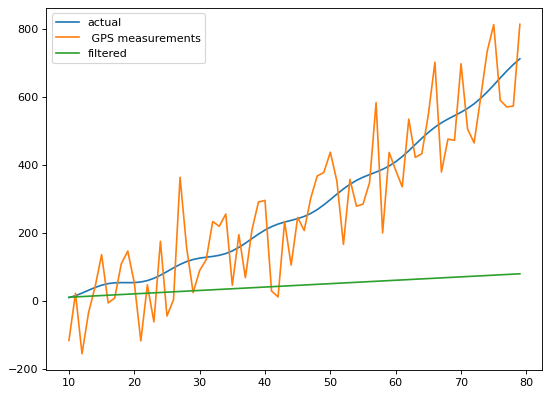

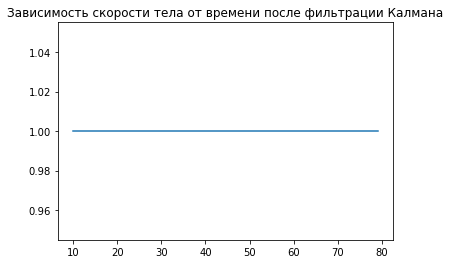

In [28]:
t = np.arange(10, 80) 
x = t + 0.1 * np.power(t, 2) + 10 * np.sin(0.5 * t)
data = x + np.random.normal(0, 100, 70)
figure(figsize=(8, 6), dpi=80)
plt.plot(t, x,label='actual')
plt.plot(t, data,label=' GPS measurements')
data_filtered, speeds = g_h_filter(data, x0=x[0], dx=1, g=0., h=0., dt=1.)
plt.plot(t, data_filtered, label='filtered')
plt.legend()
plt.figure()
plt.title('Зависимость скорости тела от времени после фильтрации Калмана')
plt.plot(t, speeds)
print(np.mean(speeds), np.std(speeds))

Нижний график показывает какаяскорость в каждый момент предсказанной модели. Так как h=0, поэтому скорость равна тому, что говорит мат модель

Подберем лучшие значения g и h по принципу минимизации MSE для данного случая:

In [29]:
errors = np.zeros((10, 10))
coeffs = np.zeros((10, 10, 2))
for i, g in enumerate(np.arange(0, 2, 0.2)):
      for j, h in enumerate(np.arange(0, 2, 0.2)):
            coeffs[i, j] = [g, h]
            data_filtered, _ = g_h_filter(data, x0=x[0], dx=1, g=g, h=h, dt=1.)

            errors[i, j] = np.sum(np.power(np.asarray(data_filtered) - np.asarray(x), 2))

minidx = np.unravel_index(errors.argmin(), errors.shape)
print(errors[minidx])
print(coeffs[minidx])

170338.60981034325
[0.2 0. ]


1.0 0.0


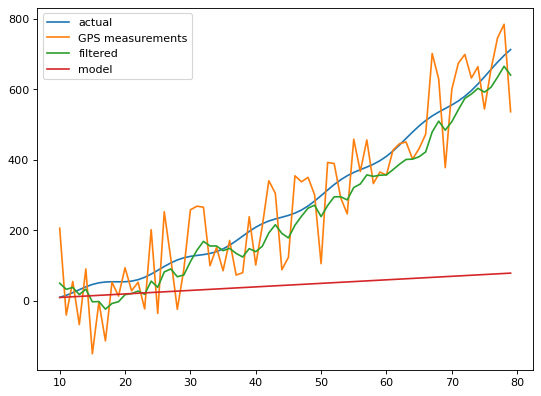

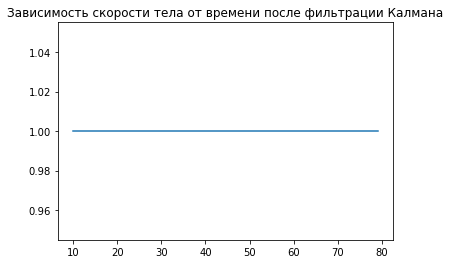

In [30]:
t = np.arange(10, 80) 
x = t + 0.1 * np.power(t, 2) + 10 * np.sin(0.5 * t)
data = x + np.random.normal(0, 100, 70)
figure(figsize=(8, 6), dpi=80);
plt.plot(t, x,label='actual')
plt.plot(t, data,label='GPS measurements')
data_filtered, speeds = g_h_filter(data, x0=x[0], dx=1, g=0.2, h=0., dt=1.)
plt.plot(t, data_filtered, label='filtered')
plt.plot(t, t, label='model')
plt.legend()
plt.figure()
plt.title('Зависимость скорости тела от времени после фильтрации Калмана')
plt.plot(t, speeds)
print(np.mean(speeds), np.std(speeds))

Нижний график показывает какаяскорость в каждый момент предсказанной модели. Так как h=0, поэтому скорость равна тому, что говорит мат модель. В данном случае лишь координата подправляется на каждом шаге предсказания реального положения. Скорость остается зафиксированной

Рассмотрим такой случай: <br/>
Тело предсказываеся моделью равномерногодвижения а на самом деле имеет еще ускорение 2 м/с^2

In [31]:
t = np.arange(10, 80) 
x = t*60 + 1 * np.power(t, 2) 
data = x + np.random.normal(0, 1000, 70)

In [32]:
errors = np.zeros((20, 20))
coeffs = np.zeros((20, 20, 2))
for i, g in enumerate(np.arange(0, 2, 0.1)):
      for j, h in enumerate(np.arange(0, 2, 0.1)):
            coeffs[i, j] = [g, h]
            data_filtered, _ = g_h_filter(data, x0=x[0], dx=1, g=g, h=h, dt=1.)

            errors[i, j] = np.sum(np.power(np.asarray(data_filtered) - np.asarray(x), 2))

minidx = np.unravel_index(errors.argmin(), errors.shape)
print(errors[minidx])
print(coeffs[minidx])

13720414.3020803
[0.3 0. ]


137.7111269068249 151.89402976368044


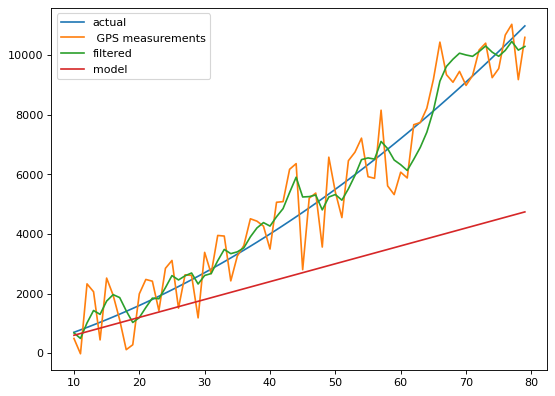

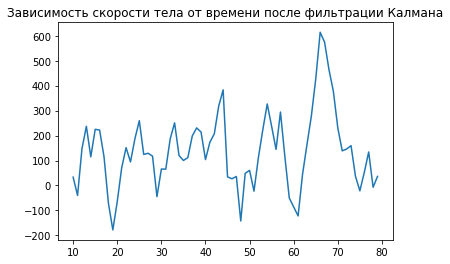

In [33]:
figure(figsize=(8, 6), dpi=80)
plt.plot(t, x,label='actual')
plt.plot(t, data,label=' GPS measurements')
data_filtered, speeds = g_h_filter(data, x0=x[0], dx=60, g=0.3, h=0.1, dt=1.)
plt.plot(t, data_filtered, label='filtered')
plt.plot(t, 60*t, label='model')
plt.legend()
plt.figure()
plt.title('Зависимость скорости тела от времени после фильтрации Калмана')
plt.plot(t, speeds)
print(np.mean(speeds), np.std(speeds))

Нижний график показывает какаяскорость в каждый момент предсказанной модели. Так как h=0.1, поэтому скорость в каждый момент времени немного корректируется по результатам значения с GPS датчика

---

### Модели предсказания временных последовательностей и определения зависимостей между рядами:

1. Даны два датасета (динамика вакцинации от ковида (А) и твиты про ковид(Б)) <br/>
https://www.kaggle.com/datasets/priteshraj10/covid-vaccination-all-countries-data<br/>
https://www.kaggle.com/datasets/gpreda/all-covid19-vaccines-tweets<br/>
2. Необходимо, используя тест Гренджера на причинность, определить, является ли процесс, описываемый датасетом А причиной процесса Б (по Гренджеру), и наоборот.
3. Используя векторную авторегрессионную модель определить, являются ли данные процессы стационарными
4. В случае, если оба процесса являются нестационарными, проверить, являются ли данные процессы коинтегрированными

In [91]:
import plotly.express as px

In [92]:
df_vac = pd.read_csv('vaccinations.csv')

In [108]:
df_vac.head()

,date,daily_vaccinations
0,2020-12-02,0.0
1,2020-12-03,0.0
2,2020-12-04,0.0
3,2020-12-05,0.0
4,2020-12-06,0.0


In [109]:
df_tweet = pd.read_csv('D:\YandexDisk\BMSTU\Программирование\Python\\vaccination_all_tweets.csv')

In [110]:
df_tweet.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False


In [111]:
df_tweet['date'] = pd.to_datetime(df_tweet['date']).dt.date

In [112]:
df_vac = df_vac.groupby(['date'])['daily_vaccinations'].sum().reset_index()
df_vac['date'] = pd.to_datetime(df_vac['date']).dt.date
df_vac.head()

,date,daily_vaccinations
0,2020-12-02,0.0
1,2020-12-03,0.0
2,2020-12-04,0.0
3,2020-12-05,0.0
4,2020-12-06,0.0


In [113]:
fig = px.bar(df_vac, x='date', y='daily_vaccinations',
             labels={'date': 'Дата', 'daily_vaccinations': 'Число вакцинирований в день'})
fig.show()

In [114]:
timeline = df_tweet.groupby(['date']).count().reset_index()
timeline['count'] = timeline['text']
timeline = timeline[['date', 'count']]
fig = px.bar(timeline, x='date', y='count', labels={'date': 'Дата', 'count': 'Чило твитов в день'})
fig.show()

In [117]:
timeline = df_vac.merge(timeline, how='outer', on='date')
timeline = timeline.dropna()

In [118]:
timeline

,date,daily_vaccinations,count
10,2020-12-12,15297.0,63.0
11,2020-12-13,50750.0,98.0
12,2020-12-14,139627.0,137.0
13,2020-12-15,371204.0,150.0
14,2020-12-16,580596.0,144.0
...,...,...,...
265,2021-08-24,141618411.0,860.0
266,2021-08-25,144342936.0,852.0
267,2021-08-26,147456968.0,1021.0
268,2021-08-27,148928388.0,928.0


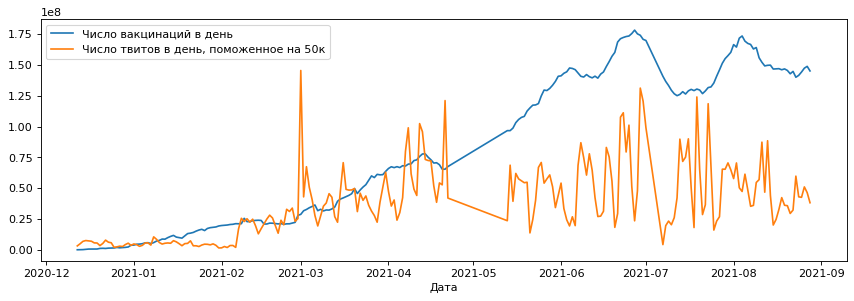

In [147]:
figure(figsize=(13, 4), dpi=80)
plt.plot(timeline.date.values, timeline['daily_vaccinations'].values, label='Число вакцинаций в день')
plt.xlabel('Дата')
plt.plot(timeline.date.values, timeline['count'].values*50000, label='Число твитов в день, поможенное на 50к')
plt.legend()
plt.show()

In [119]:
from statsmodels. tsa.stattools import grangercausalitytests

Проверка, является ли временной ряд count (число твитов) причиной для временного ряда daily_vaccinations в таблице timeline

Нулевая гипотеза: временной ряд X (число твитов) не вызывает временной ряд Y (число вакцинаций)

__Будем для этого использовать тест Гренджера на причинность:__

In [149]:
grangercausalitytests(timeline[['count', 'daily_vaccinations']], maxlag=5 );


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=25.8205 , p=0.0000  , df_denom=231, df_num=1
ssr based chi2 test:   chi2=26.1558 , p=0.0000  , df=1
likelihood ratio test: chi2=24.7945 , p=0.0000  , df=1
parameter F test:         F=25.8205 , p=0.0000  , df_denom=231, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=13.7551 , p=0.0000  , df_denom=228, df_num=2
ssr based chi2 test:   chi2=28.1134 , p=0.0000  , df=2
likelihood ratio test: chi2=26.5425 , p=0.0000  , df=2
parameter F test:         F=13.7551 , p=0.0000  , df_denom=228, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.1025  , p=0.0001  , df_denom=225, df_num=3
ssr based chi2 test:   chi2=21.9704 , p=0.0001  , df=3
likelihood ratio test: chi2=20.9914 , p=0.0001  , df=3
parameter F test:         F=7.1025  , p=0.0001  , df_denom=225, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.3195  , p=0.0022  

Нулевую гипотезу можно отвергнуть, поэтому количество ежедневной вакцинации является причиной количества твитов. т.к p<0.05

Проверка, является ли временной ряд daily_vaccinations причиной для временного ряда count (число твитов) в таблице timeline

Нулевая гипотеза: временной ряд X (число вакцинаций) не вызывает временной ряд Y (число твитов)

In [152]:
grangercausalitytests(timeline[['daily_vaccinations','count']], maxlag=5 );


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0159  , p=0.8998  , df_denom=231, df_num=1
ssr based chi2 test:   chi2=0.0161  , p=0.8991  , df=1
likelihood ratio test: chi2=0.0161  , p=0.8991  , df=1
parameter F test:         F=0.0159  , p=0.8998  , df_denom=231, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3661  , p=0.2572  , df_denom=228, df_num=2
ssr based chi2 test:   chi2=2.7921  , p=0.2476  , df=2
likelihood ratio test: chi2=2.7755  , p=0.2496  , df=2
parameter F test:         F=1.3661  , p=0.2572  , df_denom=228, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.5576  , p=0.2006  , df_denom=225, df_num=3
ssr based chi2 test:   chi2=4.8181  , p=0.1856  , df=3
likelihood ratio test: chi2=4.7688  , p=0.1895  , df=3
parameter F test:         F=1.5576  , p=0.2006  , df_denom=225, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.7695  , p=0.1360  

Нулевую гипотезу нельзя отклонить (p > 0.05), поэтому нельзя однозначно сказать, что количество твитов влияет на количество ежедневной вакцинации. Данная гипотеза оказалась статистически незначимой